### 根据质量求解密度

$$l_i = x_{i+1/2} - x_{i-1/2}$$
$$\rho = m/l$$
$$e = \frac{p}{(\gamma -1)\rho}$$

### 添加人工粘性

$$p = p + q$$
$$q_i = \left\{ \begin{aligned}
1.5\rho_il_ic_i|\frac{\partial u}{\partial x}|
            +0.06\rho_il_i^2\left(\frac{\partial u}{\partial x}\right)^2  \quad \text{if} \quad \frac{\partial u}{\partial x} <0\\
            0 \text{else}
            \end{aligned} \right.
            $$

### 右端项

$$\text{rhsu}_{i+1/2} = -\frac{(p_{i+1}- p_i)}{m_{p,i+1/2}}$$
$$\text{rhse}_i = -\frac{p_i(u_{i+1/2}-u_{i-1/2})}{m_i}$$

$$m_{p,i+1/2} \approx \frac{m_{i}+m_{i+1}}{2}$$

### 推进

$$ x  = x +dt* u$$
$$ u = u + dt* \text{rhsu}$$
$$ e = e + dt* \text{rhse}$$

### 求解新的密度和压力

$$l_i = x_{i+1/2} - x_{i-1/2}$$
$$\rho = m/l$$
$$ p = (\gamma -1)\rho e$$


In [324]:
function init()
    I = 300
    u = zeros(Float64,I+1)
    x = zeros(Float64,I+1)
    l = zeros(Float64,I)
    p = zeros(Float64,I)
    ρ = zeros(Float64,I)
    m = zeros(Float64,I)
    e = zeros(Float64,I)
    γ = 1.4
    
    Δx = 1.0/I
    l .= Δx
    
    tt = 0.14
    sf =0.1
    # init
    
    for i in 1:I 
        u[i] = 0
        
        
        if i >I/2
            p[i] = 0.1
            ρ[i] = 0.125
            m[i] =ρ[i]*Δx
        else
            p[i] = 1.0
            ρ[i] = 1.0
            m[i] = ρ[i]*Δx
        end
    end
    
    for i in 1:I+1
        x[i] = i*Δx
    end
    
    
    e = pToe(p,ρ,γ)
return sf,tt,γ,u,x,m,p
end

            
            

init (generic function with 1 method)

In [15]:
function pToe(p,ρ,γ)
    return p ./ ρ/(γ-1)
end
function eTop(e,ρ,γ)
    return (γ-1)*ρ .* e
end

eTop (generic function with 1 method)

In [192]:
function timeSolve(sf, tt,γ,u,x,m,p)
    t= 0.0

    I, = size(m)
    ρ = zeros(Float64,I)
       while t<tt
#for i in 1:1
        dt=CFL(sf,γ,x,u,p,m)
        if t+dt>tt
           dt = tt-t
        end
        u,x,p,ρ = Euler1st(γ,dt,u,x,p,m)
        t += dt
        
        println(t)
    end
#
    return u,x,p,ρ
end

timeSolve (generic function with 1 method)

In [322]:
function pre2nd(γ,dt,u,x,p,m)
    I, = size(p)
    
    l = zeros(Float64,I)
    x₀ = zeros(Float64,I+1)
    u₀ = zeros(Float64,I+1)
    e₀ = zeros(Float64,I)
    
     for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l     
    e = pToe(p, ρ,γ)    
    
    p = artificial_viscosity!(γ,l,p,ρ,x,u) 
      
    rhsu, rhse = Rhs(x,l,u,p,m)
  
    x₀  = x+ dt .* u
    u₀  = u+ dt .* rhsu
    e₀  = e+ dt .* rhse
    

    
    for i in 1:I
        l[i] = x₀[i+1]-x₀[i]
    end
    
    ρ = m ./ l
    p = eTop(e, ρ,γ)
#    p = artificial_viscosity!(γ,l,p,ρ,x₀,u₀)
    
    rhsu₀, rhse₀ = Rhs(x₀,l,u₀,p,m)
    
    x  += 1/2 *dt*(u +u₀)
    u  += 1/2 *dt*(rhsu + rhsu₀)
    e  += 1/2 *dt*(rhse + rhse₀)
    
    for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    p = eTop(e, ρ,γ)
    
    
    return u,x,p,ρ
end

pre2nd (generic function with 1 method)

In [323]:
function Euler1st(γ,dt,u,x,p,m)
    I, = size(p)
    
    l = zeros(Float64,I)
    x₀ = zeros(Float64,I+1)
    u₀ = zeros(Float64,I+1)
    e₀ = zeros(Float64,I)
    
     for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l     
    e = pToe(p, ρ,γ)    
    
    p = artificial_viscosity!(γ,l,p,ρ,x,u) 
      
    rhsu, rhse = Rhs(x,l,u,p,m)
  
    x  = x+ dt .* u
    u  = u+ dt .* rhsu
    e  = e+ dt .* rhse    
    
    for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    p = eTop(e, ρ,γ)
    
    
    return u,x,p,ρ
end


Euler1st (generic function with 1 method)

## 预估校正方法 （二阶）

$$\frac{dy}{dx} = f(x,y)$$

$$y_0 = y_n + dx f(x_n,y_n)$$

$$y_{n+1} = y_n + \frac{1}{2} dx [f(x_n, y_n) + f(x_{n+1},y_0)] $$

In [206]:
function Rhs(x,l,u,p,m)
    I, = size(m)
    rhsu = zeros(Float64,I+1)
    rhse = zeros(Float64,I)
    for i in 1:I-1
        rhsu[i+1] = - 2(p[i+1] - p[i])/(m[i] +m[i+1])
    end
    for i in 1:I
        rhse[i] = - p[i]*(u[i+1]-u[i])/m[i]
    end

    return rhsu,rhse
    
    end
    

Rhs (generic function with 1 method)

In [303]:
function artificial_viscosity!(γ, l,p,ρ,x,u)
    I, = size(p)
    for i in 1:I
        c = √(γ*p[i]/ρ[i])
        ∂u_∂x = (u[i+1]- u[i])/(x[i+1]-x[i])
        q = 0
        if ∂u_∂x < 0 
        q = 1.5ρ[i]*l[i]*c*abs(∂u_∂x)
            +2.5ρ[i]*l[i]^2*(∂u_∂x)^2 
        end
        p[i] = p[i] +q
    
    end
    return p
end

artificial_viscosity! (generic function with 1 method)

In [20]:
  function CFL(sf,γ,x,u,p,m)
    dlmin = 1e8
    umax = 0.0
    I, = size(p)
    l = zeros(Float64,I)
    ρ = zeros(Float64,I)
    
     for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    for i in 1:I
        c  = √(γ*p[i]/ρ[i])
        u2 = u[i] + c 
        if abs(u2) > umax
            umax = abs(u2)
        end
        if l[i] < dlmin
            dlmin = l[i]
        end
    end
    cfl = dlmin/umax*sf
    return cfl
end

CFL (generic function with 1 method)

In [325]:
sf,tt,γ,u,x,m,p = init()
u,x,p,ρ = timeSolve(sf, tt, γ, u, x, m,p)

0.00028171808490949944
0.0005634361698189989
0.0008369850886372683
0.001091806150966937
0.0013301621854187474
0.0015540386037109799
0.0017651479094745281
0.001964957904259138
0.0021547257544249987
0.0023355306387090853
0.0025083024377203847
0.0026738459709215894
0.0028328610977344216
0.0029859592606917024
0.003133677076666227
0.0032764875214600824
0.003414809167154557
0.0035490138469924703
0.0036794330486654937
0.0038063632758216738
0.0039300705685578335
0.004050794334816602
0.004168750614046656
0.004284134870486869
0.004397124394572667
0.0045078803760952415
0.004616549700978949
0.004723266514188239
0.004828153583801001
0.004931323495280745
0.005032879700130966
0.005132917439177779
0.005231524557513462
0.005328782225497161
0.005424765578035155
0.005519544282561971
0.005613183044643898
0.005705742058872222
0.0057972774116593715
0.0058878414416616825
0.005977483062798284
0.006066248054193786
0.006154179320823669
0.006241317128170485
0.006327699313793327
0.0064133614783624185
0.0064983371

0.03880320261476628
0.03887458808940064
0.038945972621438514
0.039017356271993486
0.03908873909825075
0.039160121154163
0.0392315024910792
0.03930288315831747
0.03937426168506777
0.03944563720864194
0.039517009839535634
0.039588379685017876
0.03965974684934401
0.03973111143397828
0.03980247353782246
0.039873833257447235
0.03994519068732365
0.04001654592005193
0.04008789904658539
0.04015925015644719
0.040230599337937926
0.040301946678332264
0.040373292264062756
0.04044463618088935
0.040515978514053155
0.04058731934841309
0.040658658766662026
0.04072999684511806
0.04080133365474974
0.0408726692620749
0.0409440037299572
0.04101533711831828
0.04108666948477871
0.0411580008852374
0.041229331374396314
0.04130066100623537
0.04137198983444075
0.04144331791278895
0.04151464529548776
0.041585972037475195
0.04165729819467658
0.04172862155051418
0.041799942182183615
0.041871260194484575
0.041942575690532787
0.04201388877195633
0.04208519953907835
0.042156508091087605
0.042227814526192405
0.0422991

0.07499621290676999
0.07506713621201322
0.0751380590093126
0.0752089813120482
0.07527990313326037
0.07535082448565804
0.07542174538162684
0.07549266583323705
0.07556358585225129
0.07563450545013212
0.07570542463804936
0.07577634342688729
0.07584726182725164
0.07591817984947648
0.0759890975036308
0.07606001479952507
0.07613093174671759
0.07620184835452068
0.0762727646320067
0.07634368058801397
0.07641459623115246
0.07648551156980948
0.07655642661215513
0.07662734136614756
0.07669825583953828
0.07676917003987718
0.0768400839745175
0.07691099738099248
0.07698191024574269
0.07705282258283525
0.07712373440598343
0.0771946457285552
0.07726555656358162
0.07733646692376503
0.07740737682148693
0.0774782862688159
0.07754919527751504
0.07762010385904951
0.07769101202459369
0.07776191978503824
0.07783282715099701
0.07790373413281375
0.07797464074056865
0.07804554698408475
0.07811645287293423
0.0781873584164444
0.07825826362370379
0.0783291685035678
0.0784000730646645
0.07847097731540006
0.07854188

0.11169727544350282
0.11176808045442545
0.11183888535358545
0.11190969014291714
0.11198049482430655
0.11205129939959256
0.11212210387056802
0.11219290823898091
0.11226371250653537
0.11233451667489278
0.11240532074567273
0.11247612472045415
0.11254692860077614
0.11261773238813905
0.11268853608400534
0.11275933968980055
0.11283014320691417
0.11290094663670051
0.11297174998047954
0.11304255321602931
0.11311335631780427
0.11318415928825862
0.1132549621297863
0.1133257648447224
0.11339656743534461
0.11346736990387452
0.113538172252479
0.1136089744832715
0.1136797765983133
0.11375057859961478
0.1138213804891366
0.11389218226879096
0.11396298394044264
0.11403378550591026
0.11410458696696729
0.11417538832534319
0.11424618958272441
0.11431699074075549
0.11438779180104001
0.1144585927651416
0.11452939363458488
0.11460019441085643
0.11467099509540568
0.11474179568964582
0.11481259619495465
0.11488339661267548
0.11495419694411789
0.11502499719055863
0.11509579735324235
0.11516659743338244
0.115237

([0.0, -1.92736e-16, -3.81849e-16, 1.02976e-16, -1.02976e-16, 0.0, 0.0, 0.0, 1.26421e-16, -1.26421e-16  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.00333333, 0.00666667, 0.01, 0.0133333, 0.0166667, 0.02, 0.0233333, 0.0266667, 0.03, 0.0333333  …  0.973333, 0.976667, 0.98, 0.983333, 0.986667, 0.99, 0.993333, 0.996667, 1.0, 1.00333], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125])

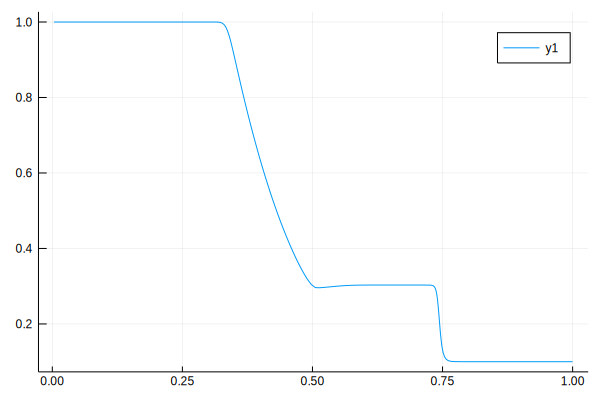

In [329]:
#using Plots
plot(x[1:end-1],p)
# plot!(x[1:end-1],p)
# plot!(x[1:end],u)
# plot!(x1 .+ 0.5,U[:,1:3])

In [100]:
push!(LOAD_PATH, "/home/bfly/workspace/computeforcfd/Lag2D/")

6-element Array{String,1}:
 "@"                                        
 "@v#.#"                                    
 "@stdlib"                                  
 "/home/bfly/workspace/computeforcfd/Lag2D/"
 "/home/bfly/workspace/computeforcfd/Lag2D/"
 "/home/bfly/workspace/computeforcfd/Lag2D/"

In [10]:
using Riemann

In [312]:
Wₗ = W(1.0,0.0,1.0)
Wᵣ = W(0.125,0.0,0.1)
γ = 1.4
x1,U = SolveDistr(0.14,Wₗ,Wᵣ,γ)

([-0.3313, -0.330472, -0.329644, -0.328816, -0.327987, -0.327159, -0.326331, -0.325503, -0.324674, -0.323846  …  0.478339, 0.479565, 0.480792, 0.482018, 0.483245, 0.484471, 0.485698, 0.486924, 0.488151, 0.489377], [1.0 0.0 1.0; 1.0 0.0 1.0; … ; 0.125 0.0 0.1; 0.125 0.0 0.1])

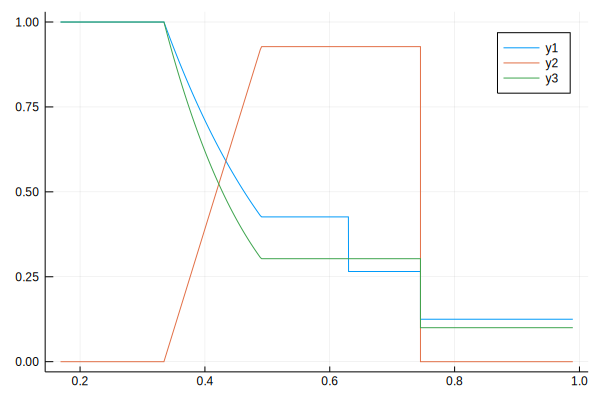

In [313]:
plot(x1 .+ 0.5,U)